# Display the development of the PDB over time

This is supplementary data for "The Life Cycle of Structural Biology Data", submitted to the Data Science Journal.

[PDBe Documentation](https://www.ebi.ac.uk/pdbe/api/doc/search.html).


## New Entries Released Each Year

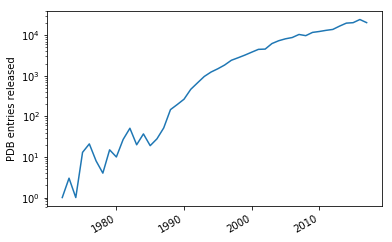

In [2]:
import pandas

PDBE_SOLR_URL = "http://www.ebi.ac.uk/pdbe/search/pdb"                 
# or https://www.ebi.ac.uk/pdbe/search/pdb/select?rows=0&q=status:REL&wt=json

from mysolr import Solr
solr = Solr(PDBE_SOLR_URL, version=4)

response = solr.search(**{
        "rows" : 0, # "fl" : "deposition_year", 
        "q" : 'status:REL',
        "facet" : "true", "facet.limit" : 1000000, "facet.mincount" : 1,
        "facet.field" : "deposition_year",
    }
)
from matplotlib import pyplot as plt

# skip current year, which is not yet complete
years = sorted( response.facets['facet_fields']['deposition_year'] )[0:-1]

fig = plt.figure()
plt.yscale('log')
plt.ylabel('PDB entries released')
plt.plot(years, [ response.facets['facet_fields']['deposition_year'][year] for year in years])
plt.xticks(['1980', '1990', '2000', '2010'])
fig.autofmt_xdate()
plt.show()

## Complexes by year
If an entry referes to more than one macromolecule (i.e. is heteromeric) then the work is more challenging that research of a single protein.

There is another case. A project might target a homodimer, or more generally a homo-oligomer. For a homomeric protein structure, the PDB does not record the submitter's judgement of whether the contacts between the molecules are complexation of biological relevance, or merely crystal contacts. So we cannot distinguish targeted work on homo-complexes from other work on single species. We therefore report simply the proportion of projects that aim at one rather than many macromolecular species.

In [8]:
# returns all values, in decreasing order of frequency
def get_values(field):
    response = solr.search(**{
        "rows" : 0, "fl" : "deposition_year", 
        "q" : 'status:REL',
        "facet" : "true", "facet.limit" : 10000000, "facet.mincount" : 1,
        "facet.field" : field,
        "group" : "true", "group.facet" : "true",
        "group.field" : "pdb_id",
    })
    return response.facets['facet_fields'][field].keys() 
values = get_values('assembly_form')
values

odict_keys(['homo', 'hetero'])

In [10]:
from string import Template

def get_timeline(field):
    response = solr.search(**{
            "rows" : 0, "fl" : "deposition_year", 
            "q" : 'status:REL',
            'json.facet': Template("""{
                deposition_year:{
                    type:range,start:1971,end:2018,gap:1,field:deposition_year,limit:20,
                    facet:{
                        facet1:{
                            type:terms, field: $field,
                            facet:{
                                grouped_facet_count:\"unique(pdb_id)\"
                            }
                        },
                        grouped_depositionyear_count:\"unique(pdb_id)\"
                    }
                }
            }""").substitute(field=field)
        }
    )
    return response.raw_content['facets']['deposition_year']['buckets']

timeline = get_timeline('assembly_form')

# see an example of an annual report
timeline[-4]

{'val': 2014,
 'count': 19875,
 'grouped_depositionyear_count': 9365,
 'facet1': {'buckets': [{'val': 'hetero',
    'count': 12649,
    'grouped_facet_count': 2244},
   {'val': 'homo', 'count': 7121, 'grouped_facet_count': 7121}]}}

In [17]:
def get_df(values, timeline):
    counts0 = {}
    for value in values+['unknown']:
        counts0[value] = 0
    rows = []
    for bucket in timeline:
        year = int(bucket['val'])
        counts = dict(counts0)
        if bucket['count'] > 0:
            total = bucket['grouped_depositionyear_count']
            for bbucket in bucket['facet1']['buckets']:
                counts[ bbucket['val'] ] = bbucket['grouped_facet_count']
                total = total - bbucket['grouped_facet_count']
            counts['unknown'] = total
        rows.append([year]+[ counts[label] for label in counts0])  

    df = pandas.DataFrame(rows, columns=['year']+ list(counts0.keys()) )
    df = df[df.year>1977]
    return df

df = get_df(list(values), timeline)
df.head()

,year,homo,hetero,unknown
7,1978,4,0,0
8,1979,9,3,0
9,1980,7,1,0
10,1981,23,2,0
11,1982,33,9,0


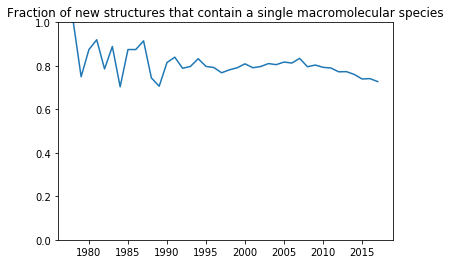

In [20]:

plt.figure()
plt.plot(df.year, df.homo/(df.homo+df.hetero) )
plt.title('Fraction of new structures that contain a single macromolecular species')
plt.ylim([0, 1])
plt.show()

# New entries, by superkingdom

In [21]:


timeline = get_timeline('superkingdom')

# see an example of the response
timeline[-4] 

{'val': 2014,
 'count': 19875,
 'grouped_depositionyear_count': 9365,
 'facet1': {'buckets': [{'val': 'Eukaryota',
    'count': 10560,
    'grouped_facet_count': 4867},
   {'val': 'Bacteria', 'count': 6930, 'grouped_facet_count': 3481},
   {'val': 'Viruses', 'count': 868, 'grouped_facet_count': 689},
   {'val': 'Archaea', 'count': 344, 'grouped_facet_count': 306}]}}

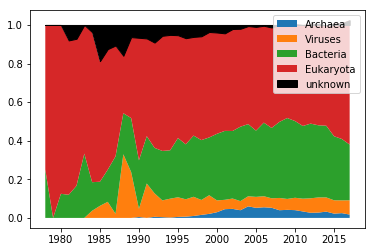

In [22]:


df = get_df(['Archaea',  'Viruses', 'Bacteria','Eukaryota' ], timeline)

def plot_df(df, values):    
    df['total'] = pandas.Series([0]*len(df), index=df.index)
    for value in values+['unknown']:
        df['total'] = df['total'] + df[value]
    plt.figure()
    running_total = pandas.Series([0]*len(df), index=df.index)
    for value in values:
        series = df[value] / df['total']
        plt.fill_between(df.year, running_total, running_total+series, label=value)
        running_total = running_total + series
    #archaea = df.Archaea/df['total']
    #viruses = df.Viruses/df['total']
    #bacteria = df.Bacteria/df['total']
    #eukaryota = df.Eukaryota/df['total']
    #plt.fill_between(df.year, archaea, archaea+viruses, label='Viruses' )
    #plt.fill_between(df.year, archaea+viruses, archaea+viruses+bacteria, label='Bacteria' )
    #plt.fill_between(df.year, archaea+viruses+bacteria, archaea+viruses+bacteria+eukaryota, label='Eukaryota' )
    plt.fill_between(df.year, running_total, [1]*len(df), color='black', label='unknown' )
    plt.legend()
    plt.show()

plot_df(df, ['Archaea',  'Viruses', 'Bacteria','Eukaryota' ])

## Count Entries by cellular location

In [44]:
values

['cytoplasm',
 'cytosol',
 'membrane',
 'extracellular region',
 'nucleus',
 'plasma membrane',
 'extracellular space',
 'extracellular exosome',
 'integral component of membrane',
 'nucleoplasm',
 'mitochondrion',
 'intracellular',
 'protein-containing complex',
 'endoplasmic reticulum',
 'periplasmic space',
 'Golgi apparatus',
 'cytoskeleton',
 'myelin sheath',
 'cell surface',
 'focal adhesion',
 'tertiary granule lumen',
 'ficolin-1-rich granule lumen',
 'perinuclear region of cytoplasm',
 'axon',
 'external side of plasma membrane',
 'endoplasmic reticulum membrane',
 'ribosome',
 'Golgi membrane',
 'outer membrane-bounded periplasmic space',
 'endoplasmic reticulum lumen',
 'nucleolus',
 'cellular_component',
 'specific granule lumen',
 'centrosome',
 'cytoplasmic vesicle',
 'MHC class I protein complex',
 'HFE-transferrin receptor complex',
 'phagocytic vesicle membrane',
 'integral component of plasma membrane',
 'intracellular membrane-bounded organelle',
 'neuron projection'

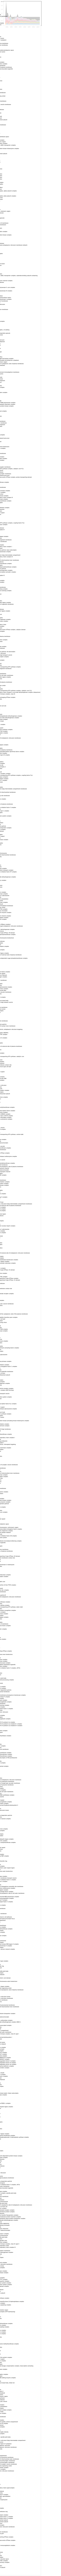

In [25]:


values = get_values("biological_cell_component")

timeline = get_timeline("biological_cell_component")
df = get_df(list(values), timeline)
plot_df(df, list(values))

## Count entries by experiment type

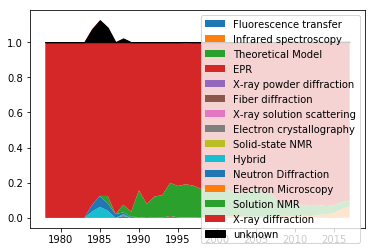

In [41]:

values = get_values("experimental_method")

timeline = get_timeline("experimental_method")
df = get_df(list(values), timeline)
plot_df(df, list(values)[::-1])